In [2]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Computing QG modes at an individual gridbox.

In [3]:
##Unparameterized run
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
fs_05 = xr.open_dataset('static.nc', decode_times=False)
os_05 = xr.open_dataset('ocean.stats.nc', decode_times=False)
av_05 = xr.open_mfdataset(['averages_00031002.nc','averages_00031502.nc'], decode_times=False)


#Contains default setup based on Jansen et al 2019. MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.15
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default/
av_05_GMBS = xr.open_mfdataset(['averages_00031002.nc','averages_00031502.nc'], decode_times=False)  

##BS Only
## MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0.0
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
av_05_BS = xr.open_mfdataset(['averages_00031002.nc','averages_00031502.nc'], decode_times=False)


##GM Only
## MEKE_VISCOSITY_COEFF_KU = -0.0; MEKE_KHCOEFF = 0.5
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7
av_05_GM = xr.open_mfdataset(['averages_00031002.nc','averages_00031502.nc'], decode_times=False)


/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default
/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7


In [25]:
#Read in various grid variables from the static file and forcing:
lon=fs_05['geolon']; lat=fs_05['geolat']
depth = fs_05['depth_ocean']

xh = fs_05.xh.values
yh = fs_05.yh.values

grid= Grid(av_05_BS, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});

u = grid.interp(av_05_BS.u[-1,0,:],axis='X')
v = grid.interp(av_05_BS.v[-1,0,:],axis='Y')


dvdx = v.differentiate('xh')*360/(6370000*2*np.pi*np.cos(lat*np.pi/180))
dudy = u.differentiate('yh')*360/(6370000*2*np.pi)
vorticity = dvdx-dudy

In [26]:
depth.shape

(280, 120)

In [27]:
#1/4 degree:560 lat x 240 lon 
#60,460 in 1/4 degree is nominal analysis point!
index_lon=30; index_lat=230 #1/4 degree: (60,460), (120,160), (60,80), (120,80), (200,80)

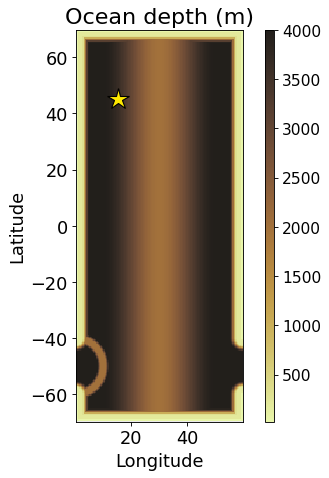

In [28]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=20,markeredgecolor='k',markerfacecolor='#FFE900')
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

Text(0.5, 1.0, 'Backscatter only $1/2^\\circ$')

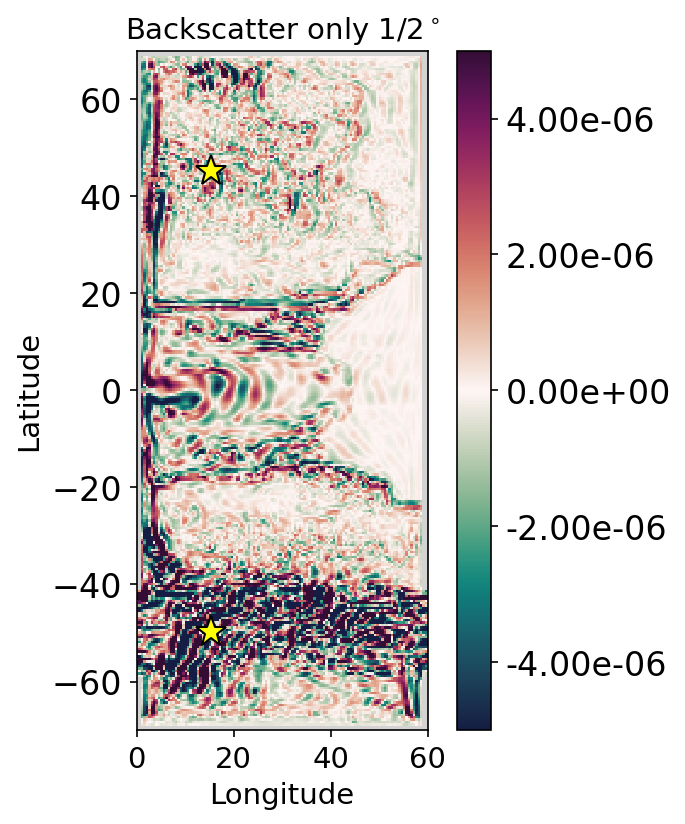

In [30]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=16)

fig = plt.figure(figsize=(5,6), dpi=150, facecolor='w', edgecolor='k')
plot1=vorticity.plot(vmin=-.5e-5,vmax=.5e-5,cmap=cmocean.cm.curl,add_colorbar=False,xlim=[0,60],ylim=[-70,70])
plt.colorbar(plot1, format='%.2e')
plt.plot(lon[40,30],lat[40,30],'*',markerfacecolor=[1,1,0],markeredgecolor='k',Markersize=15)
plt.plot(lon[230,30],lat[230,30],'*',markerfacecolor=[1,1,0],markeredgecolor='k',Markersize=15)
plt.gca().set_aspect('equal')
current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')


plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Backscatter only $1/2^\circ$',fontsize=14)
#
# plot1.set_xlim([-100,0])
# plot1.set_ylim([-80,-20])